# Forest Fires Analysis
Author: Simon Thornewill von Essen

Date: 2019-05-24

Forest fires are dangerous to human and animal lives and can cause lots of expensive damage to homes and buildings. As such, it is important firefighting is done efficiently in order to minimise costs. Towards this end, being able to predict forest fires can help with reaction time which can make fires easier to handle. This is especially germane due to global warming increasing the frequency and severity of forest fires.[[1]](https://www.c2es.org/content/wildfires-and-climate-change/) 

Some preliminary work has been done by Cortez *Et. Al.* to collect some data using relatively cheap sensors and to create a supervised learning model to regress on the total area burned by each fire. They used an SVM in order to achieve this. With a best MAD value of $12.71 \pm 0.01$ while predicting smaller fires more accurately.

I want to try and explore this dataset a little bit and see if I can create a better model using XG-Boost based on some machine learning my colleagues are performing at work on a variable with a similar distribution. 

## Importing Packages, Data and Comprehension

Before doing any serious anyalysis, the data will be imported and some basic discussion over the features in the dataset will be done. 

In [55]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
# Import the holy trinity, long may they live
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the rest...
from xgboost import XGBRegressor

from KNN_std import estimate_sigma
from pprint import pprint
from seaborn import pairplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from tqdm import *
from time import time

# Configure MPL while having a sense of taste
plt.style.use("seaborn")
%matplotlib inline

In [2]:
# Import dataset
df = pd.read_csv("../dat/forestfires.csv")

df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
# Identify shape of dataset
df.shape

(517, 13)

In this dataset we have 517 observations, 12 explanatory variables (features) and one target variable, the area.

The variables are as follows;

1. X - x-axis spatial coord for Monteshino Park
2. Y - y-axis spatial coord for M. Park
3. month - month of the year
4. day - day of the week
5. FFMC - Fine Fuel Moisture Code index of FWI system
6. DMC - Duff Moisture Code index of FWI system 
7. DC - Drought Code index of the FWI system
8. ISI - Buildup Index of the FWI system
9. temp - temperature in $C^\circ$
10. RH - relative humidity in $\%$
11. wind - wind speed in $km/h$
12. rain - rainfall in $mm/m^2$

The target variable, fire area, is measured in $ha$.

### The Canadian Forest Fire Weather Index (FWI) System

This dataset makes use of the Canadian Forest Fire Weather Index (FWI) system. [[2]](http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi) These metrics are calculated using the temp., wind, humidity and rain features of the dataset, as seen in the image below.

![FWI System](./fwi_structure.gif)

This means that although we have 13 features, we probably shouldn't use all features at once, since certain features will be able to be found within each other. This means that we should investigate which features are better predictors of our target variable. For example. Is it better to use simple Wind or Initial Spread Index? Is it better to use a combination of temp. humidity and rain or simply the duff moisture code?

### Plan of Attack and Initial Questions

First I would like to at least skim the paper associated with this dataset to try and understand the approach of Cortez *Et. Al.*. It would also be a good idea to try and implement their solution and try to achieve similar results before going on to writing my own algorithm.

Before doing any modeling however, I would also like check the data for cleanliness and tidiness before doing some EDA using visualisations. 

Finally, one of the major drawbacks of this dataset is the lack of features. Unfortunately, this means that there is a limited scope for feature engineering, which is typically responsible for the greatest increases in scores for supervised learning. However, I might be able to use the X, Y variables to create some kind of categorical variable to be used for the regression.

Leading Questions:
1. What variable has the highest correlation with burn area?
2. Can I build a model that is better than what is described in this paper?
3. Can I use the X, Y coordinates of this dataset to engineer a new variable?

### Notes After Reading Paper

The notes can be found in the `research` directory of this project. The basic gist of it is to use `c-to-1` encoding for the nominal categorical features and to normalise the rest of the featues on $N(0, 1)$. I should then fit the SVM using grid-search and 10-fold cross validation. I didn't understand anything more specific than that. So this will be my reference model for this analysis.

There was a little bit of feature engineering beyond the basic clearning that went into the dataset that I downloaded, but I didn't quite understand what they were doing and so I won't attempt much more than what I attempt to do on my own.

This means that my model may not be as performant as the one found in the paper.

## EDA: Univariate Analysis

First, we want to do a univariage analysis of the data. This means that we check the distributions and some descriptive statistics for each one as necessary. 

In [4]:
df.columns.tolist()

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'area']

Let's have a look at our features in the following order:
1. Target Variable - `area`
2. Location - `X`, `Y`
3. Time - `Month`, `Day`
4. FWI Vars - `FFMC`, `DMC`, `DC`, `ISI`
5. Meterological Data - `temp`, `RH`, `wind`, `rain`

First up, the area.

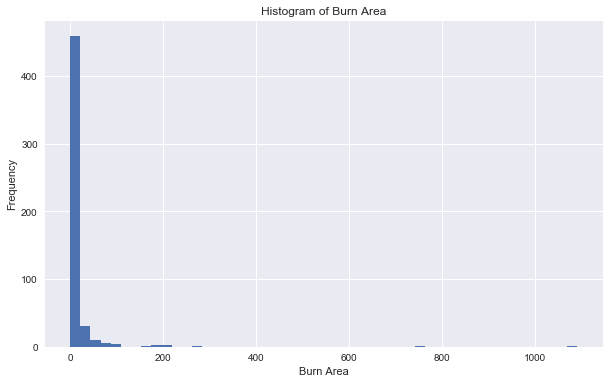

In [5]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='k')
plt.hist(df.area, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Burn Area")
plt.title("Histogram of Burn Area")
plt.show()

We can see above that this variable is *very* outlier driven, which is part of what makes it a difficult dataset to use ML on. However, in order to help make the analysis easier, Cortez *Et. Al.* used the log(n+1) plot of this varaible, so I should do this as well to help make prediction easier.

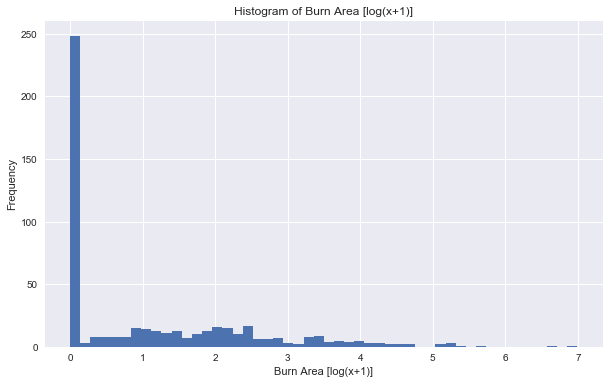

In [6]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='k')
plt.hist(np.log(df.area + 1), bins=50)
plt.ylabel("Frequency")
plt.xlabel("Burn Area [log(x+1)]")
plt.title("Histogram of Burn Area [log(x+1)]")
plt.show()

The reason why I choise to do the analysis on this dataset is because this look svery similar to a [tweedie distribution](https://www.statisticshowto.datasciencecentral.com/tweedie-distribution/). Knowing this might help me to predict this varaible a little easier.

In any case, I will create a TODO to transform our variable when it is time for modeling.

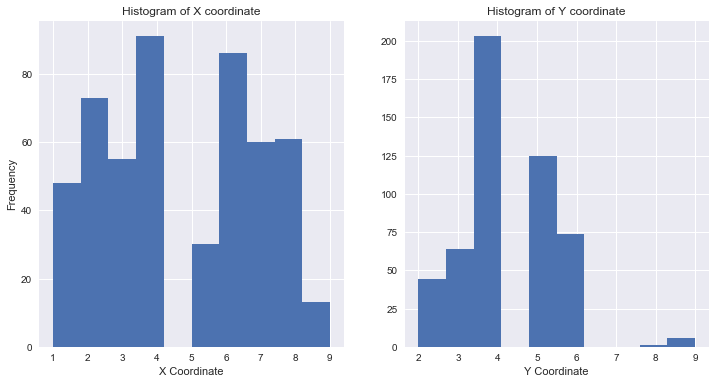

In [7]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='white', edgecolor='k')
plt.subplot(1, 2, 1)
plt.hist(df.X, bins=10)
plt.ylabel("Frequency")
plt.xlabel("X Coordinate")
plt.title("Histogram of X coordinate")
plt.subplot(1, 2, 2)
plt.hist(df.Y, bins=10)
plt.xlabel("Y Coordinate")
plt.title("Histogram of Y coordinate")
plt.show()

We can see for  for X and Y variables, that the most fires happen in the southern part of the map and not usually in the center. This might be because a small fire will be protected by some kind of wind until it is large enough to not be immediately put out by wind. Meanwhile, it also will have the most access to fuel. This is something that I investigate further in the bivariate analysis.

One thing to note is that the Y coordinates seem to be very tightly concentrated on a specific area, while the X coordinate is more spread out.

I guess that I shouldnt miss the obvious missing values at the 4,4 coordinate. This might be because there is only rock at this area or something.

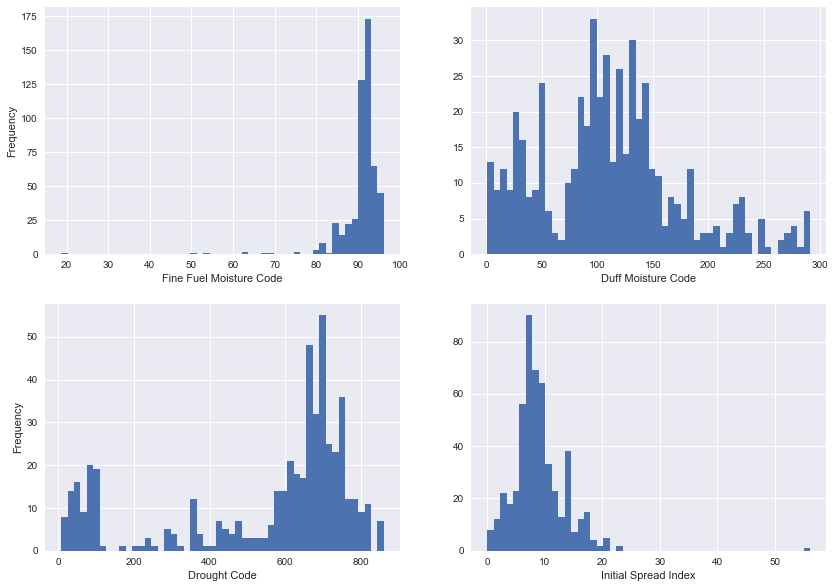

In [8]:
fig, ax = plt.subplots(figsize=(14,10), facecolor='white', edgecolor='k')
plt.subplot(2, 2, 1)
plt.hist(df.FFMC, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Fine Fuel Moisture Code")
plt.subplot(2, 2, 2)
plt.hist(df.DMC, bins=50)
plt.xlabel("Duff Moisture Code")
plt.subplot(2, 2, 3)
plt.ylabel("Frequency")
plt.hist(df.DC, bins=50)
plt.xlabel("Drought Code")
plt.subplot(2, 2, 4)
plt.hist(df.ISI, bins=50)
plt.xlabel("Initial Spread Index")
plt.show()

We can already see that each of the FWI codes can span over very different ranges. 

There seems to be a many parts in this park that have plenty of fine-fuel, very few sections have less than 60% fine fuel. 

It's interesting to see that the Moisture and Drought codes look like a loose mirror-image of each other. This kind of makes sense because they both relate to the buildup index.

Finally, we can see the initial spread index looks a little like a poisson distribution, even if there is no frequency dimention for this kind of data. (i.e. x per y) Isntead, it is probably best to think of it as a log-normal distribution.

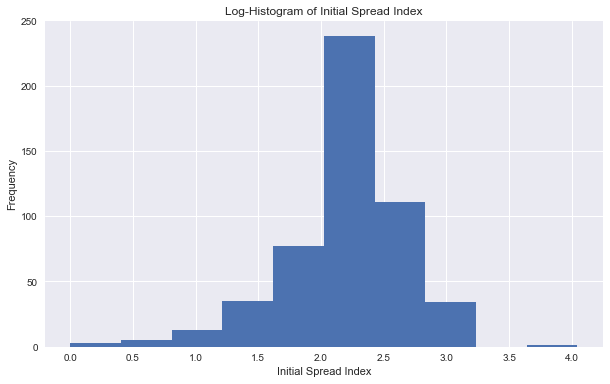

In [9]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='k')
plt.hist(np.log(df.ISI+1), bins=10)
plt.title("Log-Histogram of Initial Spread Index")
plt.xlabel("Initial Spread Index")
plt.ylabel("Frequency")
plt.show()

It seems that although it might have been an iteresting idea that the ISI was log-normal distributed, this doesn't really seem to be the case since it is still a little bit left-skewed. 

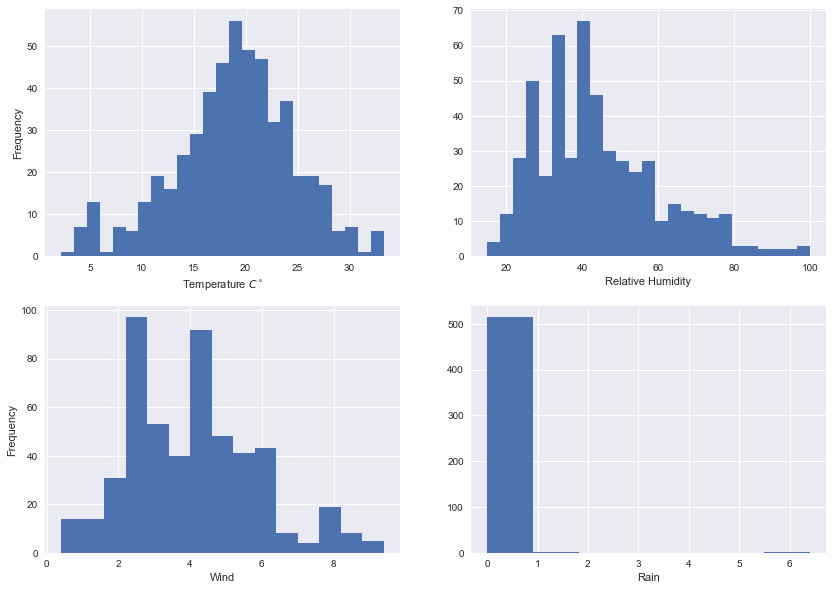

In [10]:
fig, ax = plt.subplots(figsize=(14,10), facecolor='white', edgecolor='k')
plt.subplot(2, 2, 1)
plt.hist(df.temp, bins=25)
plt.ylabel("Frequency")
plt.xlabel("Temperature $C^\circ$")
plt.subplot(2, 2, 2)
plt.hist(df.RH, bins=25)
plt.xlabel("Relative Humidity")
plt.subplot(2, 2, 3)
plt.ylabel("Frequency")
plt.hist(df.wind, bins=15)
plt.xlabel("Wind")
plt.subplot(2, 2, 4)
plt.hist(df.rain, bins=7)
plt.xlabel("Rain")
plt.show()

The most striking thing about this plot is how most days there is no rain. This would certainly help create forrest fires.

Temperature is nicely normally distributed though, which is fun to see.

Relative humidity is a little right skewed and wind varies quite a bit.

## EDA: Bivariate Analysis

For the bivariate analysis, I will create some correlation/scatter matrices to take a look at the corrlations and patterns we have in the data.

In [11]:
# Create correlation matrix
df_corr = df.copy()
df_corr["ln_area"] = df_corr["area"].apply(lambda x: np.log(x + 1))

corr = df_corr.corr()
corr.style.background_gradient(cmap='viridis')

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,ln_area
X,1,0.539548,-0.0210393,-0.0483842,-0.0859161,0.00620994,-0.0512583,0.0852232,0.0187978,0.0653872,0.0633853,0.0619949
Y,0.539548,1,-0.0463075,0.00778156,-0.101178,-0.024488,-0.0241031,0.0622207,-0.0203409,0.0332341,0.0448732,0.0388382
FFMC,-0.0210393,-0.0463075,1,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.0284848,0.0567015,0.040122,0.0467986
DMC,-0.0483842,0.00778156,0.382619,1,0.682192,0.305128,0.469594,0.0737949,-0.105342,0.07479,0.0729943,0.0671527
DC,-0.0859161,-0.101178,0.330512,0.682192,1,0.229154,0.496208,-0.0391916,-0.203466,0.0358609,0.0493832,0.0663598
ISI,0.00620994,-0.024488,0.531805,0.305128,0.229154,1,0.394287,-0.132517,0.106826,0.0676682,0.00825769,-0.0103469
temp,-0.0512583,-0.0241031,0.431532,0.469594,0.496208,0.394287,1,-0.52739,-0.227116,0.0694905,0.0978441,0.0534865
RH,0.0852232,0.0622207,-0.300995,0.0737949,-0.0391916,-0.132517,-0.52739,1,0.0694101,0.0997512,-0.0755186,-0.0536622
wind,0.0187978,-0.0203409,-0.0284848,-0.105342,-0.203466,0.106826,-0.227116,0.0694101,1,0.0611189,0.0123173,0.0669735
rain,0.0653872,0.0332341,0.0567015,0.07479,0.0358609,0.0676682,0.0694905,0.0997512,0.0611189,1,-0.00736573,0.0233113


We can see the that there is some correlation between the X and Y, coordinates. This means that fire's don't necessarily happen uniformly across the map but across a line.

Furthermore, the FWI codes are all correlated with each other. This makes sense because they are sometimes used to derive each other and as in the case with FFMC and ISI. Various indeces can also depend on the same variables. For example, FFMC, DMC and DC all depend on Temperature.

We can also see that taking the log of the area doesn't necessarily improve the correlations between the explanatory and the target variables. If I didn't know that people had creates successful models on this dataset then I might even say that there is not enough signal in the noise to create a prediction. (As a general rule of thumb, You want correlations of something like .3 or higher.)

We can also answer one of our leading questions right now! What is the variable with the highest correlation with burn area...

In [12]:
corr.query("area == {}".format(corr.query("area < 0.5241")["area"].max()))["area"]

temp    0.097844
Name: area, dtype: float64

We can see that the feature thats the most correlated with area burned is the temperature. 

This makes sense because temperature will also have a large effect on other variables that cause fires.

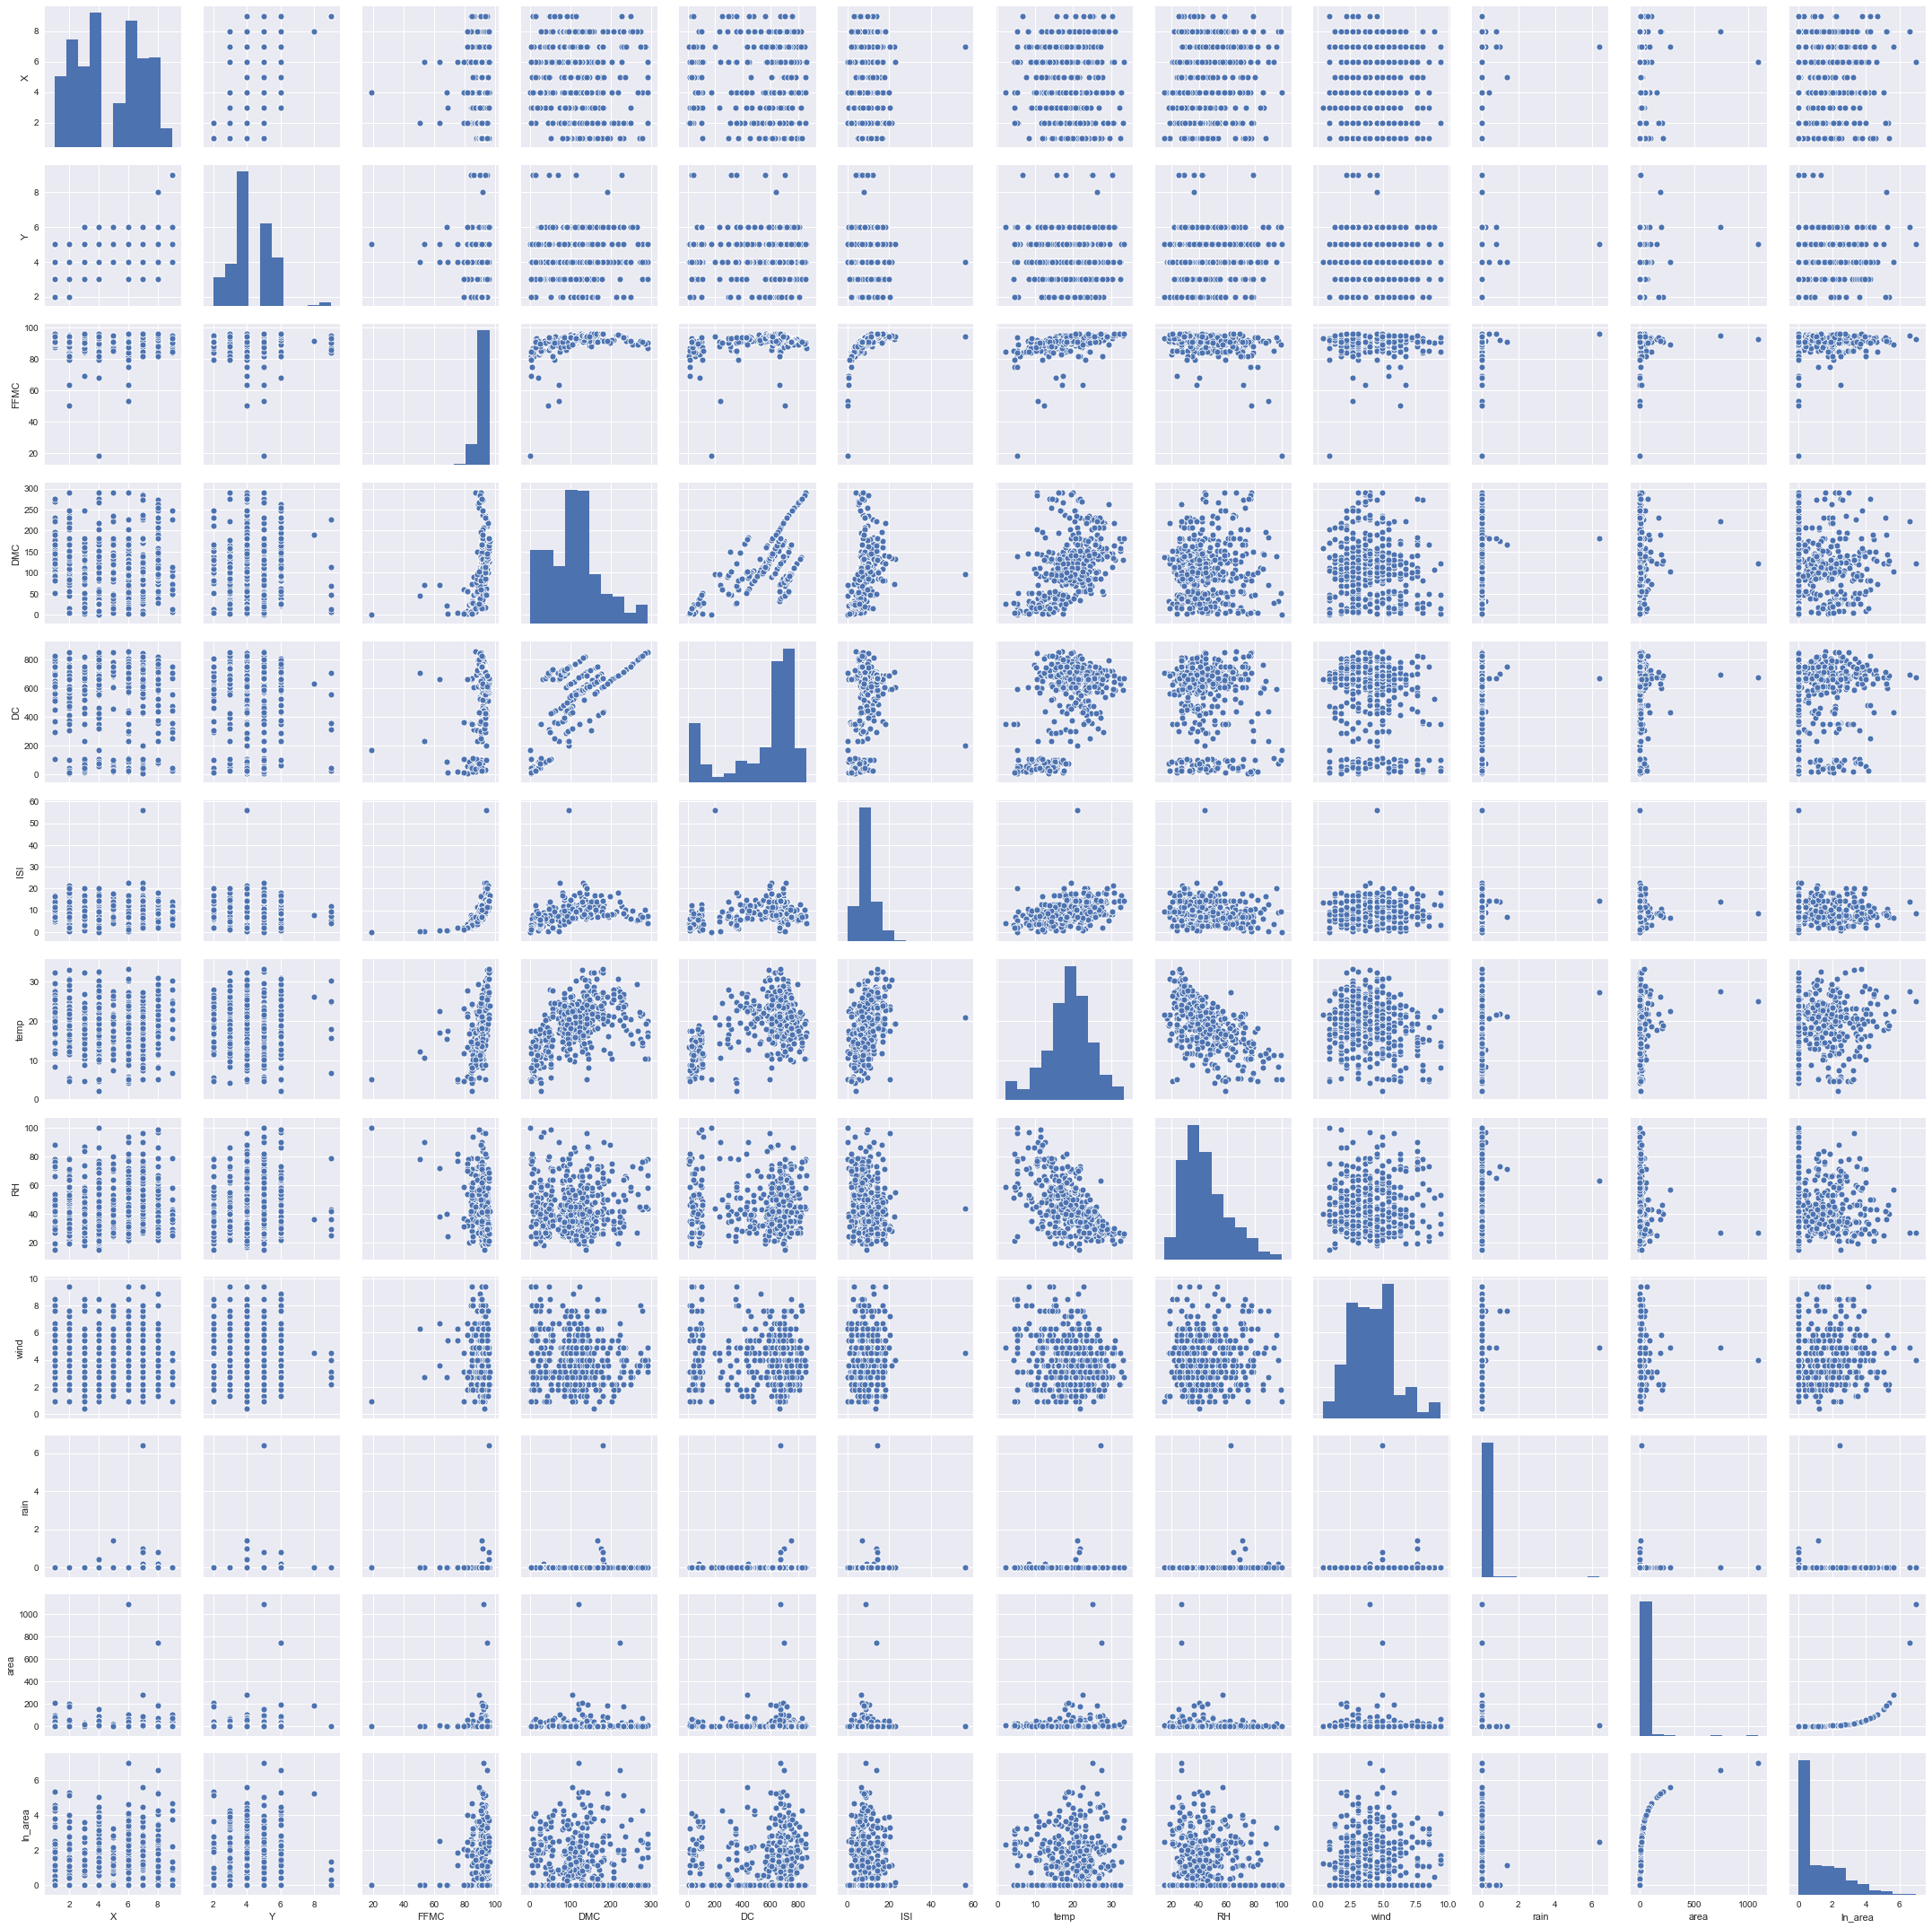

In [13]:
pairplot(df_corr)
plt.savefig("./plots/scattermatrix.png")

Using the correlations from the matrix beforehand, we can take a look at this scatter plot and take a finer look at the data. The bottom line plot is of specific interest to me. 

We can see that there are a couple of outliers in the values of our scatter plot these might make predictions more difficult to make so it might be a good idea to remove them. We will be able to see the effect later using Train-Test-Validation scoring. 

Furthermore, we can see from the (X, Y) scatter plot that the area of burns take the rough outline of the map park. So it isn't really that these variables are correlated as much as the taking the correlation coefficient reveals that the park is long as opposed to being square or circular. (This is why it's so important to make graphs.)


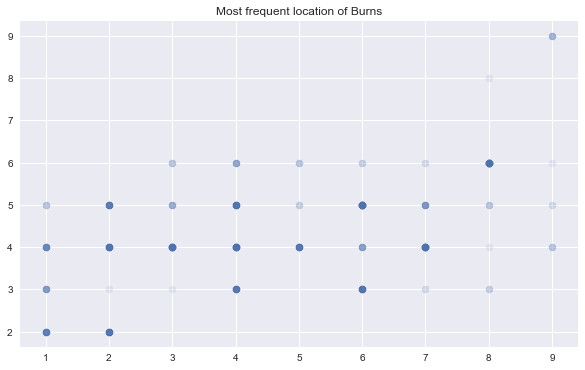

In [14]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='k')
plt.scatter(df.X, df.Y, alpha=0.1)
plt.title("Most frequent location of Burns")
plt.show()

It can be seen here that the burns aren't exactly localised in one area. So it seems that the X and Y variables might not be super important after all. Indeed, the best model by Cortez *Et. Al.* doesn't make use of X and Y at all!

## EDA: Summary

We can see from these plots that the appearance of a devastating forest fire is relatively rare, with the most frequently occuring fires being relatively small in size. There also doesn't seem to be a lot of information within the features to predict our target variable. 

It makes sense now why this dataset is supposed to be a relatively difficult one.

The variable with the highest level of correlation is the temperature. We could also see that the FWI codes all are relatively strongly correlated with each other. 

The most important take away from this section, I think, is the distribution of the target variable which is what got me interested in this dataset in the first place. This will be important when seting up the parameters for my XGBoosted model down the line.


## Data Cleaning and Feature Engineering/Selection

Looking back at the paper of Cortez *Et. Al.*, I can see that they used various feature selections. They thought of their features as four main sections:

1. Spatial - `X`, `Y`
2. Temporal - `Day`, `Month`
3. FWI - `FFMC`, `DMC`, `DC`, `ISI`
4. Weather - `temp`, `RH`, `wind`, `rain`

Upon combining different sets of features, they campe up with four categorisations

1. FWI - Only FWI features
2. M - Only weather features
3. STFWI - Spatial, Temporal and FWI features
4. STM - Spatial, Temporal and Weather Features

They found that the features with the best predictive power was M and FWI. M creates that 


In [15]:
# Check for missing values
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Luckily, we can see that there are no missing variables.

In [16]:
# Keep raw version
df_raw = df.copy()

df_raw.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [17]:
# Encode Day, Month using one hot encoding
cat_vars = ["month", "day"]
df_cv = pd.get_dummies(df_raw[cat_vars])

df_cv.head()

,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [18]:
# Normalise the rest of the variables on N(0, 1)
num_vars = df.drop(["month", "day", "area"], axis=1).columns.tolist()

transformer = Normalizer().fit(df[num_vars])
X_nv = transformer.transform(df[num_vars])

In [19]:
df_nv = pd.DataFrame(X_nv)
df_nv.columns = num_vars

df_nv.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0.049719,0.035513,0.612249,0.186090,0.669780,0.036224,0.058242,0.362235,0.047588,0.00000
1,0.010336,0.005906,0.133774,0.052270,0.987953,0.009893,0.026578,0.048726,0.001329,0.00000
2,0.010068,0.005753,0.130314,0.062856,0.987999,0.009637,0.021000,0.047465,0.001870,0.00000
3,0.050396,0.037797,0.577668,0.209775,0.488214,0.056696,0.052286,0.611055,0.025198,0.00126
4,0.045308,0.033981,0.505745,0.290534,0.578803,0.054369,0.064563,0.560680,0.010194,0.00000


In [20]:
# Join dataframes together
X = df_nv.join(df_cv)

In [21]:
# Create feature categorizations
feature_spatial = ["X", "Y"]
feature_temporal = df_cv.columns.tolist()
feature_fwi = ["FFMC", "DMC", "DC", "ISI"]
feature_weather = ["temp", "RH", "wind", "rain"]

# Create feature selection lists
features = {"FWI": feature_fwi,
           "M": feature_weather,
           "STFWI": feature_spatial+feature_temporal+feature_weather,
           "STM": feature_spatial+feature_temporal+feature_fwi}

In [22]:
# Transform y into ln(y + 1)
y = df_raw["area"].apply(lambda x: np.log(x + 1))

## ML Models: SVM

Before creating our XGBoosted model. I want to try and recreate the numbers created by Cortez *Et. Al.* to the best of my ability.

The only issue is that it's not clear what value of epsilon to use based on what is written.

![Epsilon](./epsilon.png)

My assumption is that using KNN we can find the distance between any point and its 3 closest neighbours. Then, we can take the standard deviation of these values to get an estimate for sigma on this point. This will give us a vector of deviations.

After the vector of deviations is obtained, I will then take the mean to get my estimate of sigma.

In [23]:
# Estimate sigma
sigma = estimate_sigma(X.values, 3)

print("\t est. of sigma: {}".format(sigma))

100%|██████████| 517/517 [00:02<00:00, 241.63it/s]


	 est. of sigma: 0.061288464627759845


In [24]:
# Instantiate Model
svr = SVR(C=3, epsilon=3*sigma*np.sqrt(np.log(len(X))/len(X)), gamma='auto')  # Parameters taken from paper

In [25]:
# K fold cross validation
kf = KFold(n_splits=10, random_state=42)
kf.get_n_splits(X);

In [26]:
features.keys()

dict_keys(['FWI', 'M', 'STFWI', 'STM'])

In [27]:
# Perform cross validation
MAD = []
RMSE = []
f = "M"  # Defines features for train/test

for split, indeces in enumerate(kf.split(X)):
    (train_i, test_i) = indeces
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    
    # Fit and predict
    svr.fit(X_train[features[f]], y_train)
    y_pred = svr.predict(X_test[features[f]])
    
    # Calculate scores
    MAD.append(mean_absolute_error(np.exp(y_pred), np.exp(y_test)))
    RMSE.append(mean_squared_error(np.exp(y_pred), np.exp(y_test)))
    
    
# Print MAD and RSME
np.mean(MAD), np.sqrt(np.mean(RMSE))

(13.106144745169612, 64.85021660060077)

Although the numbers for MAD and RSME reported in the paper is $12.71$ and $64.7$ respectively, I would say that these numbers show that I at least have an estimator that works. 

Let's try to recreate their plot on page 9, which is a scatter plot of the burned area in order, overlapped by the predicted values

## ML Models: XGBoost

Now, it comes to the meat and potatoes of this investigation. With our standard model that we want to measure against in hand, let's see if we can't create a better model using XGBoost.

In [100]:
params = {'objective': ['reg:tweedie'], 
         'eta': np.arange(0.1, 0.5, 0.1), 
         'gamma': np.arange(0.2, 3, 0.2), 
         'max_depth': np.arange(0, 7, 1), 
         'eval_metric': ['mae'], 
         'seed': [42]}

xgb_grid = GridSearchCV(XGBRegressor(), param_grid=params, cv=5, scoring="neg_mean_absolute_error")

In [101]:
start_time = time()
xgb_grid.fit(X, y)
end_time = time()

print("\t Search complete! Took {} minutes to run.".format(round((end_time-start_time)/60, 2)))

AttributeError: 'builtin_function_or_method' object has no attribute 'time'

In [102]:
grid_results = pd.DataFrame(xgb_grid.cv_results_)[["mean_test_score",
                                                  "std_test_score",
                                                  "params"]]

grid_results["corr_test_score"] = grid_results["mean_test_score"].apply(lambda x: np.exp(-x))

In [105]:
grid_results.sort_values(by=["corr_test_score"], ascending=True).head()

,mean_test_score,std_test_score,params,corr_test_score
0,-1.220472,0.259839,"{'eta': 0.1, 'eval_metric': 'mae', 'gamma': 0....",3.388787
294,-1.220472,0.259839,"{'eta': 0.30000000000000004, 'eval_metric': 'm...",3.388787
112,-1.220472,0.259839,"{'eta': 0.2, 'eval_metric': 'mae', 'gamma': 0....",3.388787
301,-1.220472,0.259839,"{'eta': 0.30000000000000004, 'eval_metric': 'm...",3.388787
105,-1.220472,0.259839,"{'eta': 0.2, 'eval_metric': 'mae', 'gamma': 0....",3.388787


In [115]:
# Print top parameters
grid_results.sort_values(by=["corr_test_score"], ascending=True)["params"][3]

{'eta': 0.1,
 'eval_metric': 'mae',
 'gamma': 0.0,
 'max_depth': 3,
 'objective': 'reg:tweedie',
 'seed': 42}

## ML Models: Discussion
Text.

## Conclusion
Text.